Reference: https://harishnarayanan.org/writing/artistic-style-transfer/
https://github.com/llSourcell/How-to-Generate-Art-Demo/blob/master/demo.ipynb

In [1]:
from __future__ import print_function

import os, cv2, random
import numpy as np
import pandas as pd
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'1.1.0'

In [3]:
from keras import backend as K

In [4]:
#set to Tensor flow
K.set_image_dim_ordering('tf')
K.image_dim_ordering()

'tf'

In [5]:
from keras.models import Model
from keras.applications.vgg16 import VGG16


In [6]:
height = 512
width = 512

content_image_path = 'flatiron2.jpg'
content_image = cv2.resize(cv2.imread(content_image_path), (height, width), interpolation=cv2.INTER_CUBIC).astype(np.float32)
#if using tf, image input is (row, col, channel)
content_image.shape


(512, 512, 3)

In [7]:
style_image_path = 'cezanne.gardanne.jpg'
style_image = cv2.resize(cv2.imread(style_image_path), (height, width), interpolation=cv2.INTER_CUBIC).astype(np.float32)

style_image.shape

(512, 512, 3)

we will later concatenate the representations of these two images into a common data structure.

In [8]:

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [10]:
compile_image=np.concatenate((content_array, style_array), axis=1)
compile_image.shape

(1, 1024, 512, 3)

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

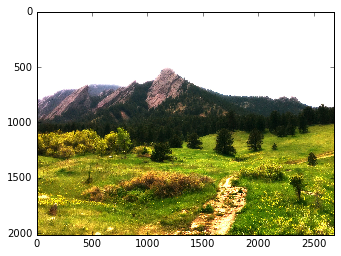

In [81]:
plt.imshow(mpimg.imread('flatiron2.jpg'))

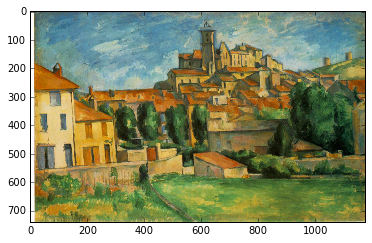

In [82]:
plt.imshow(mpimg.imread('cezanne.gardanne.jpg'))

In [11]:
compile_b=np.mean(compile_image[:, :, :, 0]).astype(np.float32) #get the blue chanel
compile_g=np.mean(compile_image[:, :, :, 1]).astype(np.float32)#get the green chanel
compile_r=np.mean(compile_image[:, :, :, 2]).astype(np.float32) #get the red chanel

In [12]:
content_array[:, :, :, 0] -= compile_b
content_array[:, :, :, 1] -= compile_g
content_array[:, :, :, 2] -= compile_r
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= compile_b
style_array[:, :, :, 1] -= compile_g
style_array[:, :, :, 2] -= compile_r
style_array = style_array[:, :, :, ::-1]

In [13]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, height, width, 3))

In [14]:
input_tensor = K.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [15]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

58867712/58889256 [============================>.] - ETA: 0s

In [16]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

# the loss function is comprised of three distinct parts: the content loss, the style loss and the total variation loss.

In [17]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [18]:
loss = K.variable(0.)

# content loss

In [19]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

# style loss

In [20]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [21]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

# Total loss

In [22]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [23]:
grads = K.gradients(loss, combination_image)

In [24]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [25]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
  
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
   

Start of iteration 0
Current loss value: 5.46223e+10
Start of iteration 1
Current loss value: 2.38704e+10
Start of iteration 2
Current loss value: 1.6927e+10
Start of iteration 3
Current loss value: 1.46259e+10
Start of iteration 4
Current loss value: 1.34799e+10
Start of iteration 5
Current loss value: 1.2857e+10
Start of iteration 6
Current loss value: 1.24594e+10
Start of iteration 7


KeyboardInterrupt: 

In [58]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += compile_b.astype('uint8')
x[:, :, 1] += compile_g.astype('uint8')
x[:, :, 2] += compile_r.astype('uint8')
x = np.clip(x, 0, 255).astype('uint8')
x.shape

(512, 512, 3)

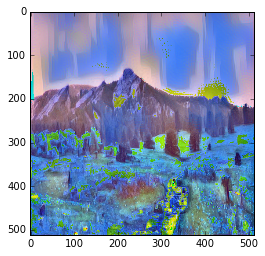

In [83]:
plt.imshow(x)